In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.tsa.stattools import coint as st_coint
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import numpy as np

import statsmodels.api as sm

import cPickle as cp
from math import sqrt
from arch.univariate import *

E:\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


如果选取价格的对数收益率进行建模，问题是残差波动太快，平均持仓周期2天左右，手续费会很高，另一方面：去除了volatility clustering之后的序列部分减少了单边趋势频繁止损的问题。  
TODO：  
如何降低波动速度？必须引入价格序列的自相关性，建立VEC模型  

In [3]:
def back_test(args): # at this version their is no stop loss
    s_score, resid_se, buy_stop_p, buy_open_p, buy_close_p, sell_stop_p, sell_open_p, sell_close_p = args
    buy_open = s_score.quantile(buy_open_p)
    buy_close = s_score.quantile(buy_close_p)
    sell_open = s_score.quantile(sell_open_p)
    sell_close = s_score.quantile(sell_close_p)
    buy_stop = s_score.quantile(buy_stop_p)
    sell_stop = s_score.quantile(sell_stop_p)
        
    signal_ar = np.zeros((len(resid_se), 1))

    
    for i in xrange(1, len(resid_se)):
        if s_score[i] < sell_open and s_score[i - 1] >= sell_open: # sell open
            signal_ar[i] = -1
        elif s_score[i] < sell_close and s_score[i - 1] >= sell_close: # sell close
            signal_ar[i] = 0
        elif s_score[i] > buy_open and s_score[i - 1] <= buy_open: # buy open
            signal_ar[i] = 1
        elif s_score[i] > buy_close and s_score[i - 1] <= buy_close: # buy close
            signal_ar[i] = 0
        elif (s_score[i] < buy_stop and s_score[i - 1] >= buy_stop) or (s_score[i] > sell_stop and s_score[i - 1] <= sell_stop):
            signal_ar[i] = 0
        else: # do nothing
            signal_ar[i] = signal_ar[i - 1]
    
    return ((resid_se[2:].values * signal_ar[:-2].T).cumsum(), buy_stop_p, buy_open_p, buy_close_p, sell_stop_p, sell_open_p, sell_close_p)

In [4]:
df = pd.read_csv("./Data/close.csv", dtype={"date": str})
df2 = (df.loc[:, ["FTF", "FXT"]]).dropna()

In [5]:
y1 = df2["FTF"].values
y2 = df2["FXT"].values

In [6]:
y2 = np.vstack((np.ones_like(y2), y2)).T
x = np.linalg.inv(y2.T.dot(y2)).dot(y2.T).dot(y1)
resid = pd.Series(y1 - y2.dot(x))

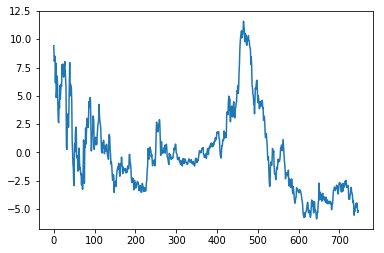

In [61]:
plt.plot(resid)

Iteration:      1,   Func. Count:      8,   Neg. LLF: 1709.29862892
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1681.82939022
Iteration:      3,   Func. Count:     29,   Neg. LLF: 1614.98237941
Iteration:      4,   Func. Count:     38,   Neg. LLF: 1605.82467972
Iteration:      5,   Func. Count:     47,   Neg. LLF: 1594.94470728
Iteration:      6,   Func. Count:     56,   Neg. LLF: 1583.24589232
Iteration:      7,   Func. Count:     65,   Neg. LLF: 1571.54548576
Iteration:      8,   Func. Count:     75,   Neg. LLF: 1569.16466694
Iteration:      9,   Func. Count:     84,   Neg. LLF: 1557.47820716
Iteration:     10,   Func. Count:     93,   Neg. LLF: 1547.40215483
Iteration:     11,   Func. Count:    102,   Neg. LLF: 1539.35265811
Iteration:     12,   Func. Count:    111,   Neg. LLF: 1534.30322755
Iteration:     13,   Func. Count:    121,   Neg. LLF: 1529.75339652
Iteration:     14,   Func. Count:    130,   Neg. LLF: 1528.41623126
Iteration:     15,   Func. Count:    139,   Neg.

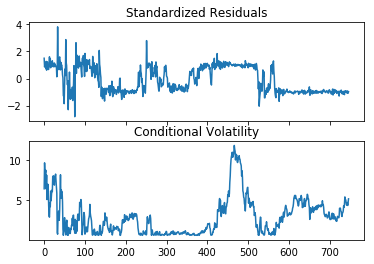

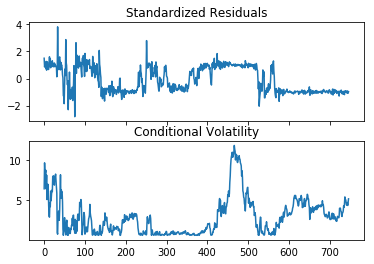

In [62]:
ar = ARX(resid, volatility=GARCH(1, 0, 1))
ar.distribution = SkewStudent()
res = ar.fit()
res.plot()

In [74]:
tt = ar.forecast(res.params)

In [81]:
float(tt.variance.iloc[-1])

25.301854943781123

In [63]:
res.params

Const      -1.866163e-01
omega       3.971146e-01
alpha[1]    1.000000e+00
beta[1]     3.103318e-13
nu          1.563481e+01
lambda      6.826506e-01
Name: params, dtype: float64

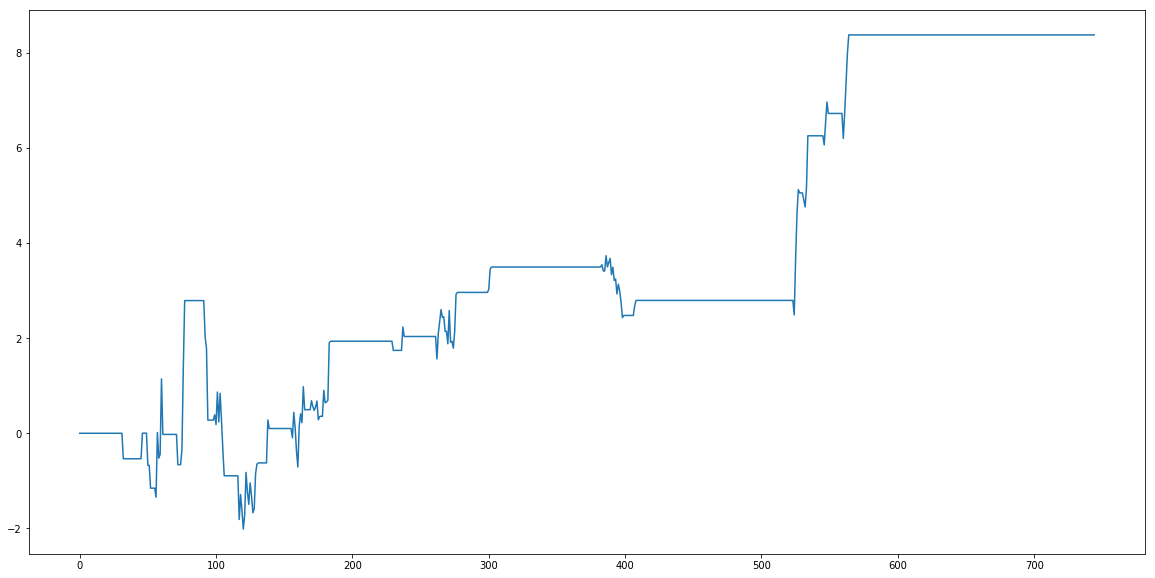

In [88]:
s_score = pd.Series(res.resid)
res2 = back_test((resid, resid.diff(), 0.25, 0.35, 0.45, 0.75, 0.65, 0.55))
fig = plt.figure(figsize=(20, 10))
plt.plot(res2[0])

In [103]:
def back_test2(y, lag, retrain=20, buy_stop_p=0.25, buy_open_p=0.35, buy_close_p=0.45, sell_stop_p=0.75, sell_open_p=0.65, sell_close_p=0.55):
    # y has two columns: y1, y2
    signal_ar = np.zeros((len(y), 1))
    beta_ar = np.zeros((len(y), 1))
    buy_stop_ar = np.zeros((len(y), 1))
    buy_open_ar = np.zeros((len(y), 1))
    buy_close_ar = np.zeros((len(y), 1))
    sell_stop_ar = np.zeros((len(y), 1))
    sell_open_ar = np.zeros((len(y), 1))
    sell_close_ar = np.zeros((len(y), 1))
    
    
    x = None
    for i in xrange(len(y)):
        if i < lag:
            continue
        
        y1 = y[i - lag : i, 0]
        y2 = y[i - lag : i, 1]
        if i % retrain == 0:
            y2 = np.vstack((np.ones_like(y2), y2)).T
            x = np.linalg.inv(y2.T.dot(y2)).dot(y2.T).dot(y1)
        
        beta_ar[i] = x[1]
        resid = pd.Series(y1 - y2.dot(x))
        
        buy_open = resid.quantile(buy_open_p)
        buy_close = resid.quantile(buy_close_p)
        sell_open = resid.quantile(sell_open_p)
        sell_close = resid.quantile(sell_close_p)
        buy_stop = resid.quantile(buy_stop_p)
        sell_stop = resid.quantile(sell_stop_p)
        
        buy_stop_ar[i] = buy_stop
        buy_open_ar[i] = buy_open
        buy_close_ar[i] = buy_close
        sell_stop_ar[i] = sell_stop
        sell_open_ar[i] = sell_open
        sell_close_ar[i] = sell_close
        
        resid = resid.values
        print resid
        
        if resid[i] < sell_open and resid[i - 1] >= sell_open: # sell open
            signal_ar[i] = -1
        elif resid[i] < sell_close and resid[i - 1] >= sell_close: # sell close
            signal_ar[i] = 0
        elif resid[i] > buy_open and resid[i - 1] <= buy_open: # buy open
            signal_ar[i] = 1
        elif resid[i] > buy_close and resid[i - 1] <= buy_close: # buy close
            signal_ar[i] = 0
        elif (resid[i] < buy_stop and resid[i - 1] >= buy_stop) or (resid[i] > sell_stop and resid[i - 1] <= sell_stop):
            signal_ar[i] = 0
        else: # do nothing
            signal_ar[i] = signal_ar[i - 1]
            
    return ((y1 - y2[:, 1] * beta_ar)[2:] * signal_ar[:-2].T).cumsum()

In [94]:
df.loc[:, ["FTF", "FXT"]].dropna().values

In [10]:
def rolling_quantile(arr,lags,q_list):
    from scipy.stats.mstats import mquantiles
    n = len(arr)
    m = len(q_list)
    result = np.zeros([n,m])*np.nan
    for i in range(n - lags + 1):
        ts =  arr[i : i + lags]
        result[i + lags - 1] = mquantiles(ts,q_list)
    return result

In [13]:
res = rolling_quantile(resid, 20, [0.25, 0.35, 0.45, 0.55, 0.65, 0.75])

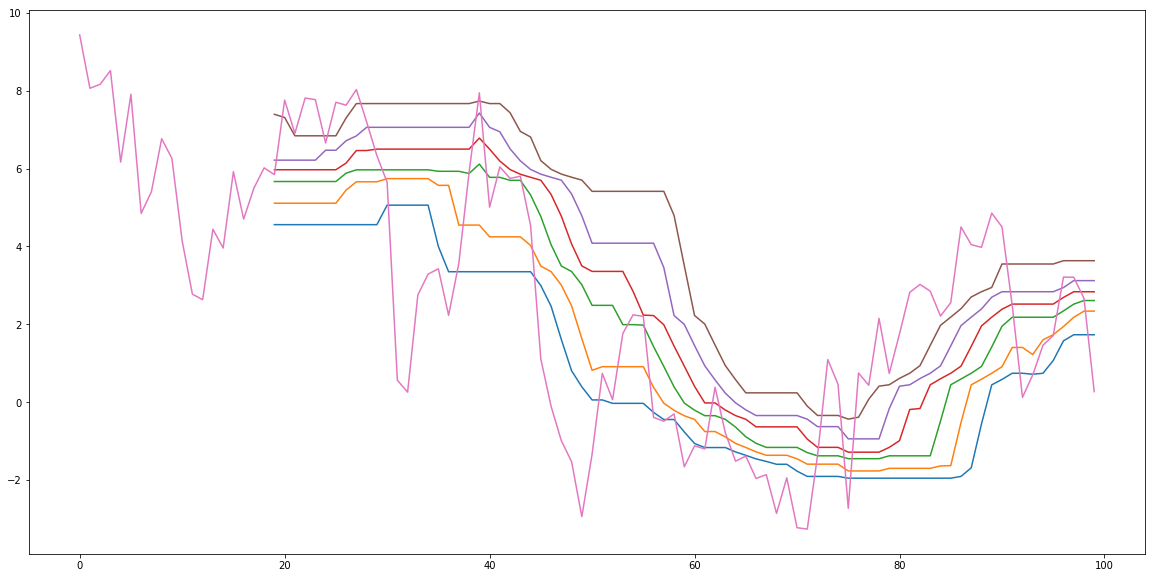

In [17]:
fig = plt.figure(figsize=(20, 10))
plt.plot(res[:100])
plt.plot(resid[:100])

In [9]:
dir(ssm)

['__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 'absolute_import',
 'argstoarray',
 'chisquare',
 'compare_medians_ms',
 'count_tied_groups',
 'describe',
 'division',
 'f_oneway',
 'find_repeats',
 'friedmanchisquare',
 'gmean',
 'hdmedian',
 'hdquantiles',
 'hdquantiles_sd',
 'hmean',
 'idealfourths',
 'kendalltau',
 'kendalltau_seasonal',
 'kruskal',
 'kruskalwallis',
 'ks_2samp',
 'ks_twosamp',
 'kurtosis',
 'kurtosistest',
 'linregress',
 'mannwhitneyu',
 'median_cihs',
 'meppf',
 'mjci',
 'mode',
 'moment',
 'mquantiles',
 'mquantiles_cimj',
 'msign',
 'normaltest',
 'obrientransform',
 'pearsonr',
 'plotting_positions',
 'pointbiserialr',
 'print_function',
 'rankdata',
 'rsh',
 'scoreatpercentile',
 'sem',
 'sen_seasonal_slopes',
 'skew',
 'skewtest',
 'spearmanr',
 'theilslopes',
 'tmax',
 'tmean',
 'tmin',
 'trim',
 'trima',
 'trimboth',
 'trimmed_mean',
 'trimmed_mean_ci',
 'trimmed_std',
 'trimmed_stde',
 'trimmed_var',
 'trimr',
 'trimtail',
 'tsem'